In [1]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Loading the dataset
df = pd.read_csv("uganda_traffic_forecasting.csv")
#Initial inspection
print(df.head(10).to_string())

          timestamp location_id vehicle_count    avg_speed weather day_of_week is_holiday     event sensor_status road_condition target_congestion_level
0  01/01/2023 03:00      ENT002            23  40.72036861   Clear    Thursday          0    Parade          FAIL           Good                       0
1  01/01/2023 03:15      GUL004            15   37.8779103   Rainy     Tuesday          0    Parade          FAIL           Poor                       1
2  01/01/2023 03:30      GUL004            21   30.4808154   Clear    Saturday          1  Marathon            OK       Moderate                       2
3  01/01/2023 03:45      MBR003            25  40.77480519   Rainy      Monday          0       NaN       UNKNOWN            ???                       0
4  01/01/2023 04:00      GUL004            15   42.5775254   Snowy      Friday          0  Marathon            OK       Moderate                       1
5  01/01/2023 04:30      ENT002            19  43.34176417   Foggy   Wednesday    

In [3]:
# More inspection 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   timestamp                1537 non-null   object
 1   location_id              1534 non-null   object
 2   vehicle_count            1536 non-null   object
 3   avg_speed                1537 non-null   object
 4   weather                  1533 non-null   object
 5   day_of_week              1533 non-null   object
 6   is_holiday               1534 non-null   object
 7   event                    1155 non-null   object
 8   sensor_status            1538 non-null   object
 9   road_condition           1536 non-null   object
 10  target_congestion_level  1537 non-null   object
dtypes: object(11)
memory usage: 132.3+ KB


In [4]:
#Checking the dataset shape
print(f'The dataset has { df.shape[0] } rows  and {df.shape[1]} columns ')

The dataset has 1538 rows  and 11 columns 


In [5]:
#Inspecting the data types
print("The data types for each column are below:")
df.dtypes

The data types for each column are below:


timestamp                  object
location_id                object
vehicle_count              object
avg_speed                  object
weather                    object
day_of_week                object
is_holiday                 object
event                      object
sensor_status              object
road_condition             object
target_congestion_level    object
dtype: object

In [6]:
#Descriptive statistics
df.describe().T

,count,unique,top,freq
timestamp,1537,1413,???,4
location_id,1534,5,MBR003,401
vehicle_count,1536,30,21,130
avg_speed,1537,1413,???,4
weather,1533,5,Rainy,396
day_of_week,1533,7,Saturday,250
is_holiday,1534,3,1,764
event,1155,4,Accident,408
sensor_status,1538,4,OK,526
road_condition,1536,4,Poor,523


In [7]:
#Checking for null values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


timestamp                    1
location_id                  4
vehicle_count                2
avg_speed                    1
weather                      5
day_of_week                  5
is_holiday                   4
event                      383
sensor_status                0
road_condition               2
target_congestion_level      1
dtype: int64

In [8]:
#Percentage of missing values for each column
print("Percentage of missing values for each column")
df.isnull().sum()* 100 / df.shape[0]

Percentage of missing values for each column


timestamp                   0.065020
location_id                 0.260078
vehicle_count               0.130039
avg_speed                   0.065020
weather                     0.325098
day_of_week                 0.325098
is_holiday                  0.260078
event                      24.902471
sensor_status               0.000000
road_condition              0.130039
target_congestion_level     0.065020
dtype: float64

In [9]:
#Replacing the  symbols with NaN
symbols = ["??",'N/A', '???', '-', 'NULL', '']
df.replace(symbols, np.nan, inplace=True)

nan_timestamp = df[df['timestamp'].isnull()]
print(nan_timestamp.to_string())

    timestamp location_id vehicle_count    avg_speed weather day_of_week is_holiday     event sensor_status road_condition target_congestion_level
132       NaN      KLA001            20  35.88506855   Rainy     Tuesday          1       NaN          FAIL           Poor                       0
460       NaN      KLA001            16  18.94353058   Snowy      Monday          1    Parade            OK           Poor                       1
499       NaN      GUL004            23  17.83181161   Rainy      Monday          0  Accident          FAIL           Poor                       4
731       NaN      ENT002            24  35.02429162   Rainy      Friday          0    Parade       UNKNOWN           Poor                       1
766       NaN      MBR003            25  46.54975584   Foggy      Friday          1  Accident       UNKNOWN       Moderate                       3


In [10]:
# Handling missing values


# This captures location-specific and time-specific traffic patterns

#timestamp in a wrong format and converting it to a correct data type
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')

df['timestamp'] = df['timestamp'].fillna(method='ffill') + pd.Timedelta(minutes=15)

# Correct day_of_week using timestamp
# Fixing  inconsistencies (e.g., 01/01/2023 incorrectly labeled as Tuesday)
df['day_of_week'] = df['timestamp'].dt.day_name()

# Extract hour_of_day for group-based imputation
# Must be created before groupby to avoid KeyError
df['hour_of_day'] = df['timestamp'].dt.hour


# Numerical columns: Imputing missing values with median by location_id and hour_of_day

num_cols = ['vehicle_count', 'avg_speed', 'is_holiday', 'target_congestion_level']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby(['location_id', 'hour_of_day'])[col].transform(lambda x: x.fillna(x.median()))
    df[col] = df[col].fillna(df[col].median())  

# Converting integer columns to int type safely after filling missing values
int_cols = ['target_congestion_level', 'vehicle_count', 'is_holiday']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

df[int_cols] = df[int_cols].astype(int)

# For categorical columns
cat_cols = ['weather', 'day_of_week', 'event', 'sensor_status', 'road_condition']

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Drop rows with missing location_id
df = df.dropna(subset=['location_id'])


C:\Users\5roy\AppData\Local\Temp\ipykernel_10124\2494824319.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['timestamp'] = df['timestamp'].fillna(method='ffill') + pd.Timedelta(minutes=15)
C:\Users\5roy\AppData\Local\Temp\ipykernel_10124\2494824319.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\5roy\AppData\Local\Temp\ipykernel_10124\2494824319.py:33: FutureWarning: A val

In [11]:


# df['timestamp'] = df['timestamp'].fillna(method='ffill') + pd.Timedelta(minutes=15)


# Correct day_of_week using timestamp
# Fixing  inconsistencies (e.g., 01/01/2023 incorrectly labeled as Tuesday)
df['day_of_week'] = df['timestamp'].dt.day_name()

# Checking  if the timestamp column has been filled correctly
print(df['timestamp'].isnull().sum(), "missing values in timestamp after filling")

print("Missing values per column after handling:")
print(df.isnull().sum())

print("\nTotal missing values after handling:")
print(df.isnull().sum().sum())

0 missing values in timestamp after filling
Missing values per column after handling:
timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
hour_of_day                0
dtype: int64

Total missing values after handling:
0


In [12]:
# Wrong Data Types
columnss =['vehicle_count','avg_speed','is_holiday','target_congestion_level']

for col in columnss:
    if col in df.columns:
# Remove extreme outliers (beyond 3 standard deviations)
       mean = df[col].mean()
       std = df[col].std()
       df[col] = np.where((df[col] < mean - 3*std) | (df[col] > mean + 3*std), np.nan, df[col])
       df[col] = df[col].fillna(df[col].median())
       




In [13]:

# Checking for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 72


In [14]:
# Removing duplicates within the columns
df = df.drop_duplicates()
print("Number of rows after removing duplicates:", df.shape[0])

# Checking  for duplicates dates
print("Number of duplicate dates:", df['timestamp'].duplicated().sum())

# Removing duplicate dates
df = df.drop_duplicates(subset=['timestamp'], keep='first')




print("Number of duplicate rows after eliminating them:", df.duplicated().sum())

Number of rows after removing duplicates: 1457
Number of duplicate dates: 51
Number of duplicate rows after eliminating them: 0


In [15]:
#Checking whether the dataset has symbols like ('??', 'N/A', '-', '', 'null','NaN','error')
df.apply(lambda col: col.isin(['??', 'N/A', '-', '', 'null','NaN','error']).sum())


timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
hour_of_day                0
dtype: int64

In [16]:
print("Data types after cleaning the dataset:")
print(df.dtypes)


Data types after cleaning the dataset:
timestamp                  datetime64[ns]
location_id                        object
vehicle_count                     float64
avg_speed                         float64
weather                            object
day_of_week                        object
is_holiday                        float64
event                              object
sensor_status                      object
road_condition                     object
target_congestion_level           float64
hour_of_day                         int32
dtype: object


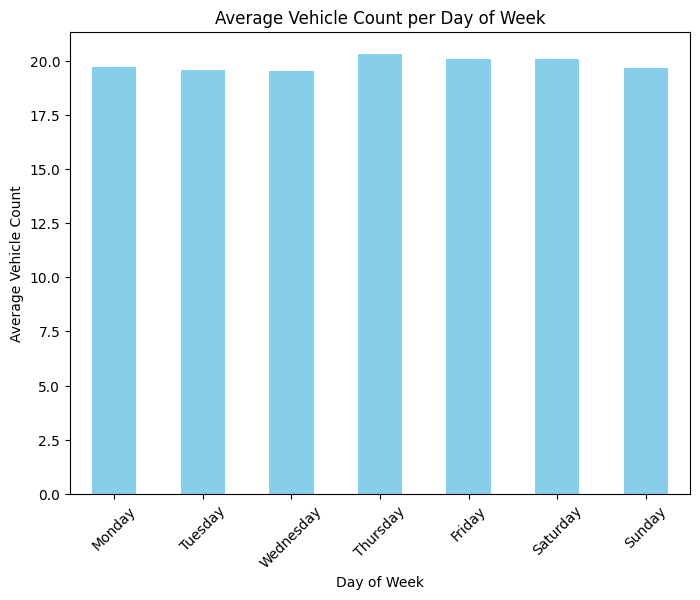

In [17]:
plt.figure(figsize=(8,6))
avg_vehicle_day = df.groupby('day_of_week')['vehicle_count'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
avg_vehicle_day.plot(kind='bar', color='skyblue')
plt.title('Average Vehicle Count per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Vehicle Count')
plt.xticks(rotation=45)
plt.show()


In [18]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'




import plotly.express as px

fig = px.scatter_3d(df,
                    x='avg_speed',
                    y='vehicle_count',
                    z='target_congestion_level',
                    color='day_of_week',
                    opacity=0.7,
                    title='3D Scatter Plot: Speed, Vehicle Count, and Congestion Level')
fig.show()


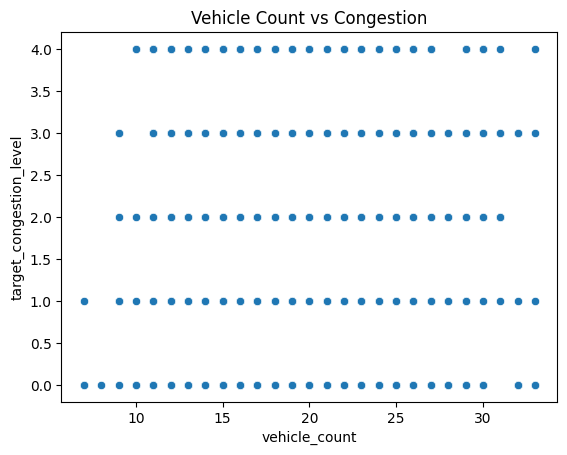

In [19]:
# Scatter plot: vehicle count vs congestion
sb.scatterplot(data=df, x='vehicle_count', y='target_congestion_level')
plt.title("Vehicle Count vs Congestion")
plt.show()

In [20]:
#Encode categorical columns into numbers and Converts each unique category label into a single integer number.
for col in ['weather', 'day_of_week', 'event', 'sensor_status', 'road_condition','location_id']:
                lu = LabelEncoder()
                df[col] = lu.fit_transform(df[col])

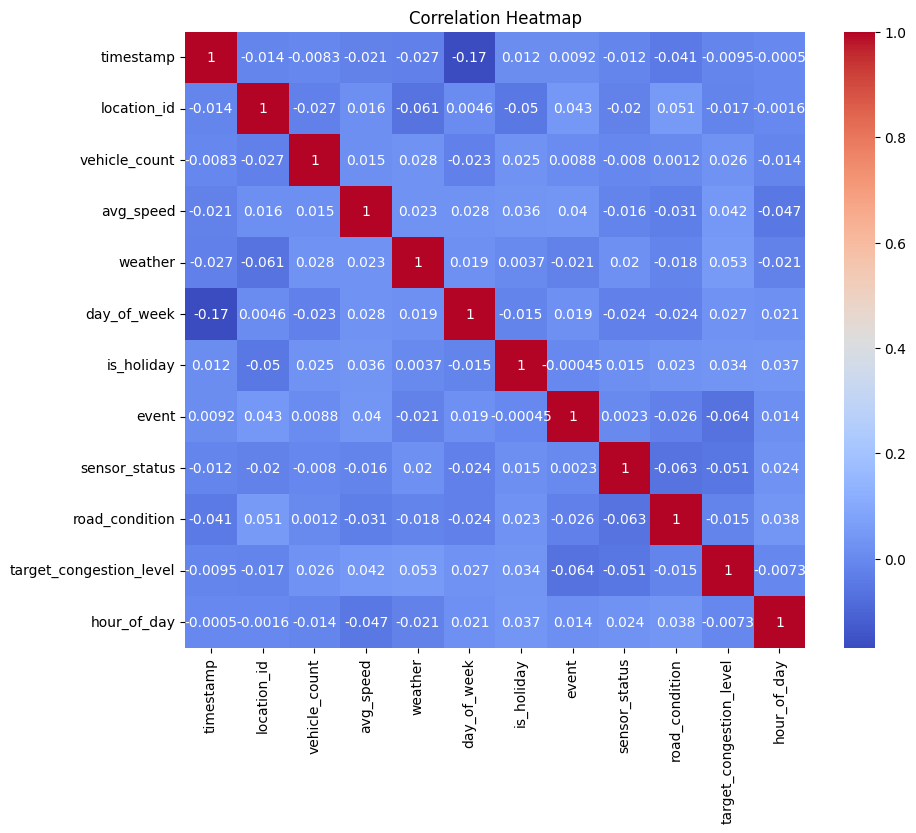

In [21]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sb.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [22]:
# Feature engineering to capture additional patterns
# is_weekend: Binary feature for weekend vs. weekday traffic patterns
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

# weather_road_interaction: Combines weather and road condition effects
df['weather_road_interaction'] = df['weather'].astype(str) + '_' + df['road_condition'].astype(str)


# event_holiday_interaction: Captures combined effect of events and holidays
df['event_holiday_interaction'] = df['event'].astype(str) + '_' + df['is_holiday'].astype(str)


# avg_speed_binned: Bins avg_speed to capture non-linear effects
bins = [0, 20, 40, 60, 100]
labels = ['Low', 'Medium', 'High', 'Very High']
df['avg_speed_binned'] = pd.cut(df['avg_speed'], bins=bins, labels=labels, include_lowest=True)

In [23]:
# Encode categorical variables for model compatibility
cat_cols = ['location_id', 'weather', 'day_of_week', 'event', 'sensor_status', 
            'road_condition', 'weather_road_interaction', 'event_holiday_interaction', 
            'avg_speed_binned']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [24]:
# Prepare features and target
X = df[['location_id', 'vehicle_count', 'avg_speed', 'weather', 'day_of_week', 
        'is_holiday', 'event', 'road_condition', 'hour_of_day', 
        'is_weekend', 'weather_road_interaction', 'event_holiday_interaction', 
        'avg_speed_binned']]
y = df['target_congestion_level']

# Scale numerical features to improve model 
scaler = StandardScaler()
X[['vehicle_count', 'avg_speed', 'hour_of_day']] = scaler.fit_transform(
    X[['vehicle_count', 'avg_speed', 'hour_of_day']])

C:\Users\5roy\AppData\Local\Temp\ipykernel_10124\215753142.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
from sklearn.ensemble import RandomForestClassifier

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
from xgboost import XGBClassifier

# Train XGBoost model
class_weights = {i: 1.0 / count for i, count in df['target_congestion_level'].value_counts().items()}
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss',scale_pos_weight=class_weights)
xgb_model.fit(X_train, y_train)

c:\Users\5roy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning:

[11:12:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.




,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [27]:
from sklearn.model_selection import cross_val_score

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


Random Forest CV Accuracy: 0.18 ± 0.02


c:\Users\5roy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning:

[11:12:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.


c:\Users\5roy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning:

[11:12:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.


c:\Users\5roy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning:

[11:12:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.


c:\Users\5roy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning:

[11:12:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.


c:\Users\5roy\AppData\Local\

XGBoost CV Accuracy: 0.18 ± 0.02


In [28]:
from sklearn.metrics import classification_report

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

print("Random Forest Test Performance:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost Test Performance:")
print(classification_report(y_test, y_pred_xgb))

Random Forest Test Performance:
              precision    recall  f1-score   support

         0.0       0.18      0.27      0.21        49
         1.0       0.12      0.19      0.15        52
         2.0       0.19      0.12      0.15        58
         3.0       0.13      0.08      0.10        61
         4.0       0.25      0.21      0.23        62

    accuracy                           0.17       282
   macro avg       0.17      0.17      0.17       282
weighted avg       0.18      0.17      0.17       282

XGBoost Test Performance:
              precision    recall  f1-score   support

         0.0       0.19      0.27      0.22        49
         1.0       0.11      0.15      0.13        52
         2.0       0.14      0.10      0.12        58
         3.0       0.16      0.10      0.12        61
         4.0       0.25      0.24      0.25        62

    accuracy                           0.17       282
   macro avg       0.17      0.17      0.17       282
weighted avg       

In [29]:
from sklearn.metrics import accuracy_score

# Compare model performance with and without new features (Task 6)
X_orig = df[['location_id', 'vehicle_count', 'avg_speed', 'weather', 'day_of_week', 
             'is_holiday', 'event', 'sensor_status', 'road_condition']]
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_orig, y, test_size=0.2, random_state=42)
model_orig = RandomForestClassifier(random_state=42)
model_orig.fit(X_train_orig, y_train)
y_pred_orig = model_orig.predict(X_test_orig)
print("Accuracy with original features:", accuracy_score(y_test, y_pred_orig))
print("Classification Report (Original Features):\n", classification_report(y_test, y_pred_orig))
print("Accuracy with new features (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("Classification Report (New Features):\n", classification_report(y_test, y_pred_xgb))

Accuracy with original features: 0.16666666666666666
Classification Report (Original Features):
               precision    recall  f1-score   support

         0.0       0.15      0.18      0.16        49
         1.0       0.15      0.27      0.20        52
         2.0       0.10      0.07      0.08        58
         3.0       0.23      0.16      0.19        61
         4.0       0.22      0.16      0.19        62

    accuracy                           0.17       282
   macro avg       0.17      0.17      0.16       282
weighted avg       0.17      0.17      0.16       282

Accuracy with new features (XGBoost): 0.1702127659574468
Classification Report (New Features):
               precision    recall  f1-score   support

         0.0       0.19      0.27      0.22        49
         1.0       0.11      0.15      0.13        52
         2.0       0.14      0.10      0.12        58
         3.0       0.16      0.10      0.12        61
         4.0       0.25      0.24      0.25    

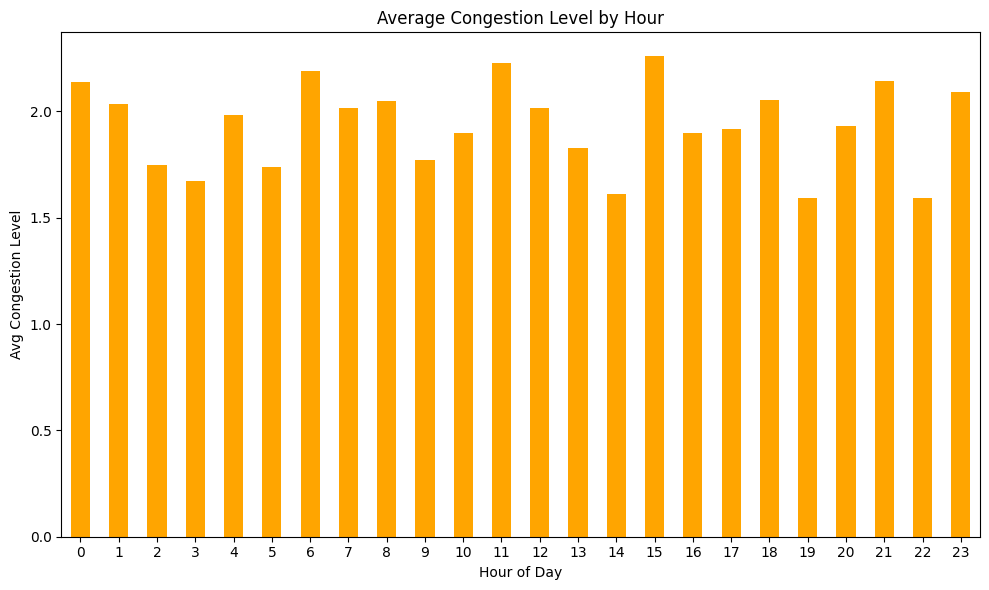

In [30]:
# Group by hour and calculate mean congestion level
avg_congestion_by_hour = df.groupby('hour_of_day')['target_congestion_level'].mean()

# Plot bar chart
plt.figure(figsize=(10, 6))
avg_congestion_by_hour.plot(kind='bar', color='orange')
plt.title('Average Congestion Level by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Congestion Level')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

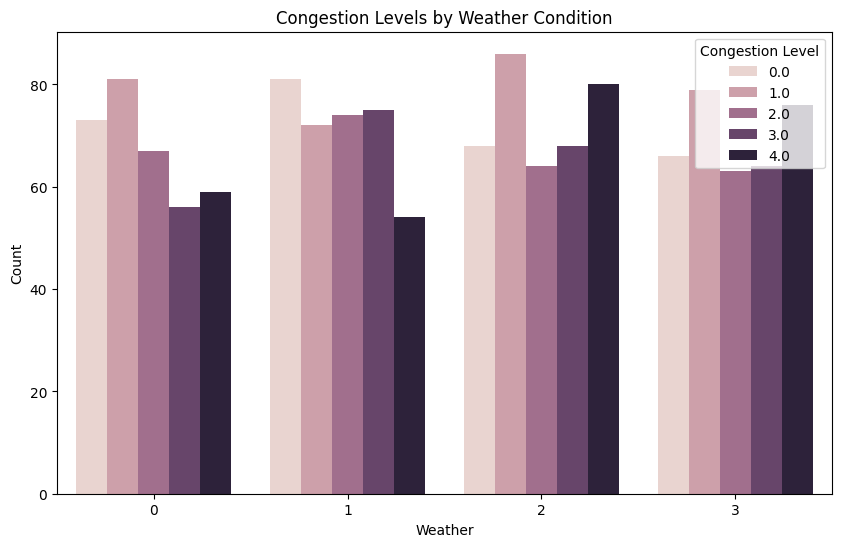

In [31]:
# Bar plot: Congestion by weather condition
plt.figure(figsize=(10, 6))
sb.countplot(data=df, x='weather', hue='target_congestion_level')
plt.title('Congestion Levels by Weather Condition')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.legend(title='Congestion Level')
plt.savefig('weather_congestion.png')
plt.show()

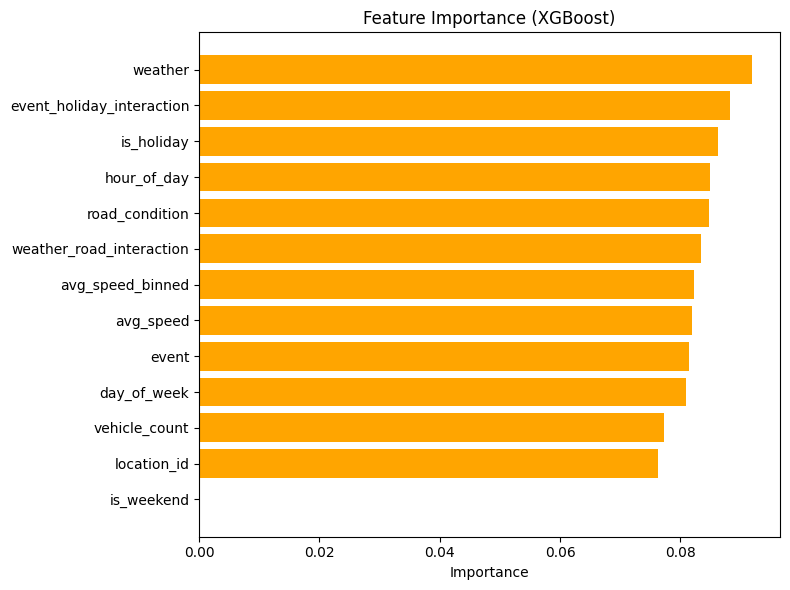

In [32]:
# Feature importance

# Get feature importances
importances = xgb_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Sort features and their importances accordingly
sorted_features = X.columns[indices]
sorted_importances = importances[indices]

# Plot horizontal bar chart with sorted features
plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_importances, color='orange')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.tight_layout()
plt.show()

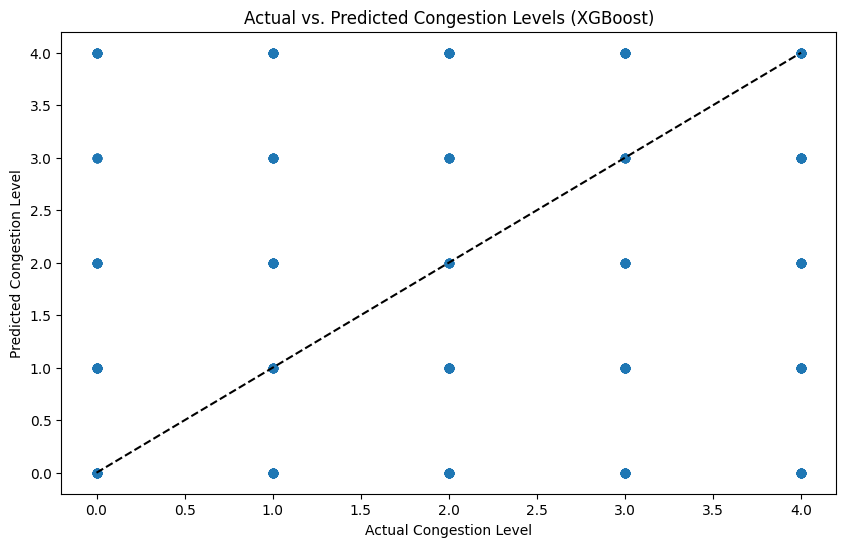

In [33]:
# Plot actual vs. predicted congestion levels
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, color='#1f77b4')
plt.plot([0, 4], [0, 4], 'k--') # diagonal line
plt.xlabel('Actual Congestion Level')
plt.ylabel('Predicted Congestion Level')
plt.title('Actual vs. Predicted Congestion Levels (XGBoost)')
plt.savefig('actual_vs_predicted.png')
plt.show()